In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import sys

sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling, print_ds_var_list, set_attrs
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, c_p, lapse_dry
from isca_tools.convection.base import lcl_metpy
import isca_tools
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import matplotlib
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
# plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
import os
from numba import jit
import metpy
from geocat.comp.interpolation import interp_hybrid_to_pressure
print(os.getcwd())

/home/users/jamd1/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa


In [8]:
path = '/home/users/jamd1/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/pre_industrial/output_lev.nd2'
ds_lev = xr.open_dataset(path).sel(quant=95).isel(plev=0)[['TREFHT', 'PREFHT', 'PS', 'ZREFHT']]
ds_lev = ds_lev.load()

In [8]:
var_keep = ['P0', 'hyam', 'hybm', 'PS', 'TREFHT', 'QREFHT', 'T', 'Z3', 'Q']
ds = cesm.load_dataset('e.e20.E1850TEST.f09_g17.daily_output', hist_file=1, year_files=50)[var_keep]

In [21]:
def preprocess(ds, lat=-24, lon=134):
    return ds.sel(lat=lat, lon=lon, method='nearest')
ds = cesm.load_dataset('e.e20.E1850TEST.f09_g17.daily_output', hist_file=1, preprocess=preprocess)[var_keep]

In [22]:
hyam = ds.hyam.isel(time=0).load()
hybm = ds.hybm.isel(time=0).load()
P0 = float(ds.P0.isel(time=0))
ds = ds.drop_vars(['P0', 'hyam', 'hybm'])

In [23]:
ds = ds.load()

In [24]:
# ds.to_netcdf('/home/users/jamd1/Isca/jobs/cesm/theory_adiabat/ds_specific_lat_lon.nd2')

In [43]:
ds = xr.load_dataset('/home/users/jamd1/Isca/jobs/cesm/av_profile/above_TREFHTquant/T/co2_2x/output.nd2')

In [48]:
ds_use = ds.T.sel(lat=20, lon=80, method='nearest').load()

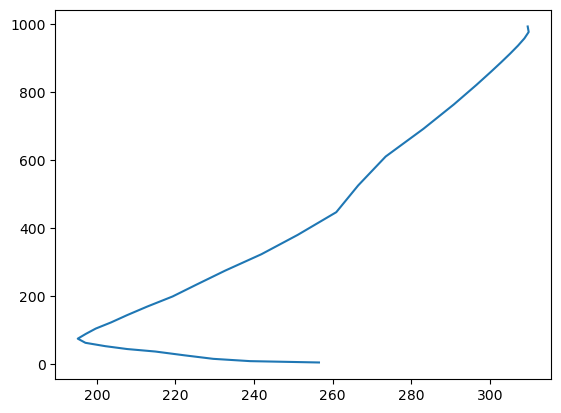

In [53]:
plt.plot(ds_use.isel(time=140), ds_use.lev)

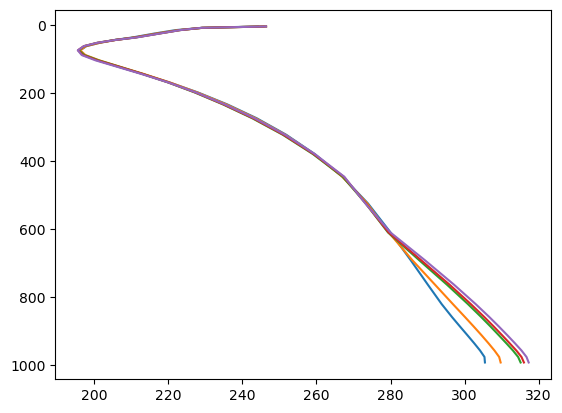

In [44]:
ds_use = ds.T.sel(lat=20, lon=80, method='nearest')
for j in range(ds.quant.size):
    plt.plot(ds_use.isel(quant=j), ds_use.lev)
plt.gca().invert_yaxis()

(240.0, 250.0)

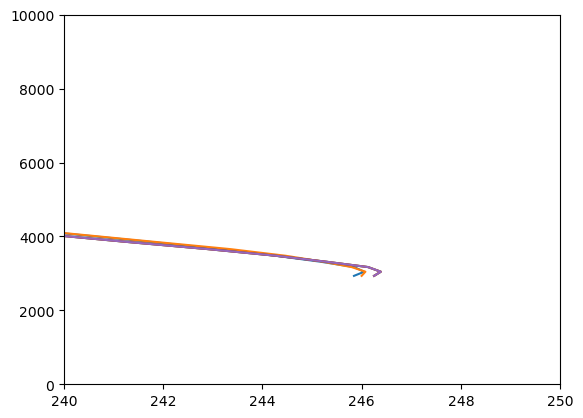

In [23]:
ds = xr.load_dataset('/home/users/jamd1/Isca/jobs/cesm/av_profile/TZ_above_TREFHTquant/test/output.nd2')
ds_use = ds.isel(lat=0, lon=0)
for j in range(ds.quant.size):
    plt.plot(ds_use.T.isel(quant=j), ds_use.Z3.isel(quant=j))
plt.ylim(0, 10000)
plt.xlim(240, 250)

In [ ]:
ds = ds.transpose([''])

In [17]:
getattr(ds.T, 'median')(dim='time')

<xarray.DataArray 'T' (lat: 192, lon: 288, lev: 32)> Size: 7MB
dask.array<nanmedian, shape=(192, 288, 32), dtype=float32, chunksize=(192, 288, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6

In [10]:
ds.T.median(dim='time')

<xarray.DataArray 'T' (lev: 32, lat: 192, lon: 288)> Size: 7MB
dask.array<nanmedian, shape=(32, 192, 288), dtype=float32, chunksize=(32, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6

In [9]:
ds.T

<xarray.DataArray 'T' (time: 365, lev: 32, lat: 192, lon: 288)> Size: 3GB
dask.array<open_dataset-T, shape=(365, 32, 192, 288), dtype=float32, chunksize=(365, 32, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time     (time) object 3kB 0050-01-02 00:00:00 ... 0051-01-01 00:00:00
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean

In [3]:
ds = ds.load()

In [4]:
ds_z2m = isca_tools.cesm.load.load_z2m()
ds_z2m = ds_z2m.load()

## Temp profile play

In [10]:
@jit
def _at_txx_ufunc(t2m,y):
    return y[np.argmax(t2m)]


def xr_of_txx(t2m,y): # Find the level of a variable on the annual hottest day for each location
    return xr.apply_ufunc(_at_txx_ufunc, t2m, y,
                             input_core_dims=[['time'],['time']],
                            dask ='parallelized',
                            vectorize=True,
                            output_dtypes=[y.dtype])

In [49]:
temp_profile_xx = xr_of_txx(ds.TREFHT, ds.T).compute()
z_profile_xx = xr_of_txx(ds.TREFHT, ds.Z3).compute()
PS_xx = xr_of_txx(ds.TREFHT, ds.PS).compute()
QREFHT_xx = xr_of_txx(ds.TREFHT, ds.QREFHT).compute()

In [58]:
QREFHT_xx = xr_of_txx(ds.TREFHT, ds.QREFHT).compute()

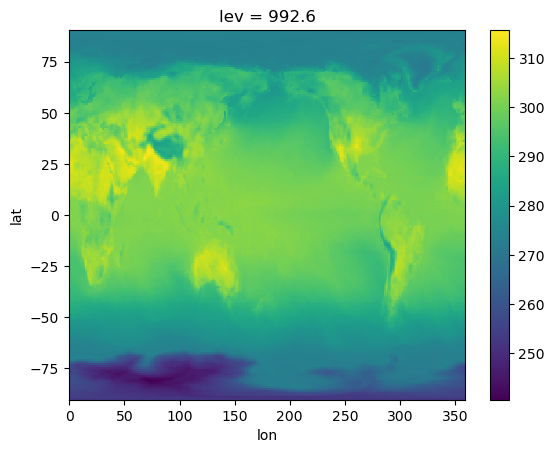

In [66]:
temp_profile_xx.sel(lev=np.inf, method='nearest').plot()

In [59]:
p0 = float(ds.P0[0])
pressure_xx = cesm.get_pressure(PS_xx, p0, hya=ds.hyam.isel(time=0), hyb=ds.hybm.isel(time=0))
mse_sat_xx = moist_static_energy(temp_profile_xx, sphum_sat(temp_profile_xx, pressure_xx), z_profile_xx)
mse_xx = moist_static_energy(temp_profile_xx, QREFHT_xx, z_profile_xx)

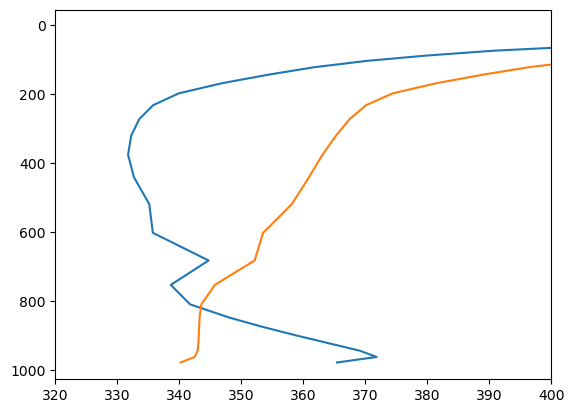

In [74]:
lat_plot = 44
lon_plot = 275
plt.plot(mse_sat_xx.sel(lat=lat_plot, lon=lon_plot, method='nearest'),
         pressure_xx.sel(lat=lat_plot, lon=lon_plot, method='nearest')/100)
plt.plot(mse_xx.sel(lat=lat_plot, lon=lon_plot, method='nearest'),
         pressure_xx.sel(lat=lat_plot, lon=lon_plot, method='nearest')/100)
plt.xlim(320, 400)
plt.gca().invert_yaxis()

In [78]:
ds_use = ds.sel(lat=lat_plot, lon=lon_plot, method='nearest').load()

In [82]:
ds_use['mse'] = moist_static_energy(ds_use.T, ds_use.QREFHT, ds_use.Z3)
ds_use['pressure'] = cesm.get_pressure(ds_use.PS, p0, hya=ds.hyam.isel(time=0), hyb=ds.hybm.isel(time=0))
ds_use['mse_sat'] = moist_static_energy(ds_use.T, sphum_sat(ds_use.T, ds_use.pressure), ds_use.Z3)

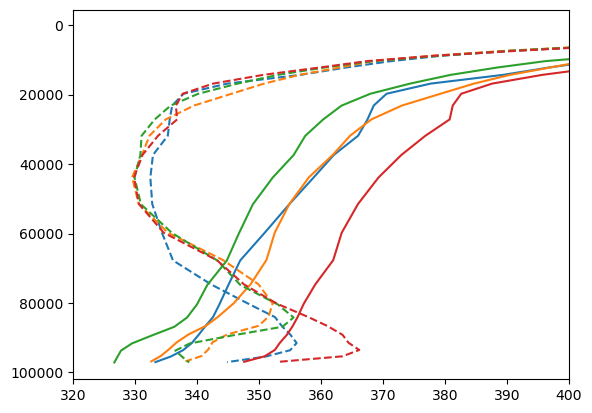

In [99]:
time_ind_plot = int(ds_use.mse.sel(lev=np.inf, method='nearest').argmax())
for i in range(time_ind_plot-3, time_ind_plot+1):
    plt.plot(ds_use.mse_sat.isel(time=i), ds_use.pressure.isel(time=i), linestyle='--', color=f"C{i-(time_ind_plot-3)}")
    plt.plot(ds_use.mse.isel(time=i), ds_use.pressure.isel(time=i), color=f"C{i-(time_ind_plot-3)}")
plt.xlim(320, 400)
plt.gca().invert_yaxis()

## LCL Play

In [6]:
def get_lcl_metpy(t_2m, q_2m, pressure_surf, z_2m):
    # Extract and convert to units
    q = q_2m.values * metpy.units.units('kg/kg')
    T = t_2m.values * metpy.units.units.kelvin
    P = pressure_surf.values  * metpy.units.units.pascal

    # Calculate dewpoint from mixing ratio
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(P, q)
    lcl_pressure, lcl_temperature = metpy.calc.lcl(P, T, dewpoint)
    dims = t_2m.dims
    coords = t_2m.coords

    # Convert MetPy Quantities to numpy arrays and units to attributes
    lcl_pressure_xr = xr.DataArray(
        data=lcl_pressure.magnitude,
        dims=dims,
        coords=coords,
        name='lcl_pressure',
        attrs={'units': str(lcl_pressure.units), 'long_name': 'LCL pressure'}
    )

    lcl_temperature_xr = xr.DataArray(
        data=lcl_temperature.magnitude,
        dims=dims,
        coords=coords,
        name='lcl_temperature',
        attrs={'units': str(lcl_temperature.units), 'long_name': 'LCL temperature'}
    )

    lapse_dry = g/c_p
    z_lcl = z_2m + (t_2m - lcl_temperature_xr) / lapse_dry
    return lcl_pressure_xr, lcl_temperature_xr, z_lcl

In [5]:
p_lcl, temp_lcl = lcl_metpy(ds.TREFHT, ds.QREFHT, ds.PS)
z_lcl = ds_z2m + (ds.TREFHT - temp_lcl) / lapse_dry

In [45]:
plev_step = 1000
plevs = np.arange(np.floor(float(p_lcl.min())),
                  np.ceil(float(p_lcl.max())) + plev_step, plev_step)

In [47]:
T_interp = interp_hybrid_to_pressure(
    data=ds['T'],      # [time, level, lat, lon]
    ps=ds['PS'],       # [time, lat, lon]
    hyam=ds['hyam'].isel(time=0),
    hybm=ds['hybm'].isel(time=0),
    p0=float(ds['P0'].isel(time=0)),
    new_levels=plevs, extrapolate=True, variable='other'
)  # Output: [time, level_interp, lat, lon]

In [48]:
T_interp = T_interp.load()

In [49]:
plevs_expand = xr.DataArray(
    plevs,
    dims=["plev"],
    coords={"plev": np.arange(len(plevs))}
).expand_dims(time=ds.time, lat=ds.lat, lon=ds.lon).transpose("time", "plev", "lat", "lon")

In [50]:
idx_closest = np.abs(plevs_expand - p_lcl).argmin(dim='plev')

In [51]:
T_at_lcl = T_interp.isel(plev=idx_closest)

In [105]:
ds_saved_test = xr.open_mfdataset('/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/archive/test/pressure_levels/lcl/*.nc').load()

In [119]:
xr.load_dataset('/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/archive/e.e20.E1850TEST.f09_g17.daily_output/pressure_levels/lcl/0048.nc')

<xarray.Dataset> Size: 969MB
Dimensions:    (lat: 192, lon: 288, time: 365)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 3kB 0048-01-02 00:00:00 ... 0049-01-01 00:00:00
Data variables:
    p_lcl      (time, lat, lon) float64 161MB 6.572e+04 6.572e+04 ... 9.557e+04
    T_lcl      (time, lat, lon) float64 161MB 246.9 246.9 246.9 ... 226.8 226.8
    Z3_lcl     (lat, lon, time) float64 161MB 3.122e+03 3.234e+03 ... 335.3
    p_at_lcl   (time, lat, lon) float64 161MB 6.6e+04 6.6e+04 ... 9.6e+04
    T_at_lcl   (time, lat, lon) float64 161MB 246.6 246.6 246.6 ... 239.5 239.5
    Z3_at_lcl  (time, lat, lon) float64 161MB 3.128e+03 3.128e+03 ... 313.5

In [63]:
pbar = tqdm(total=ds.lat.size*ds.lon.size)
for j in range(ds.lat.size):
    for k in range(ds.lon.size):
        ds_use = ds.isel(lat=j, lon=k)
        for i in range(ds_use.time.size):
            T_plevels = interp_hybrid_to_pressure(
                data=ds_use['T'].isel(time=i),
                ps=ds_use['PS'].isel(time=i),
                hyam=ds['hyam'].isel(time=0),
                hybm=ds['hybm'].isel(time=0),
                p0=float(ds.P0.isel(time=0)),
                new_levels=np.asarray([p_lcl.isel(time=i, lat=j, lon=k)])
            )
            T_plevels.load()
        pbar.update(1)

  0%|          | 0/55296 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Loop over all files, convert to float32 and re-save

In [2]:
dir_resave = '/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/archive/e.e20.E1850TEST.f09_g17.co2_0_5x_daily_output/pressure_levels/lcl/'
file_names = os.listdir(dir_resave)
for i in tqdm(range(len(file_names))):
    ds_use = xr.open_dataset(os.path.join(dir_resave, file_names[i]))
    try:
        ds_use.load()
    except Exception as e:
        print(file_names[i], e)
    # ds_use = ds_use.astype('float32')
    # encoding = {var: {'zlib': True, 'complevel': 4} for var in ds_use.data_vars}
    # ds_use.to_netcdf(os.path.join(dir_resave, file_names[i]), encoding=encoding)

  0%|          | 0/30 [00:00<?, ?it/s]

In [208]:
ds_avg = xr.load_dataset('/home/users/jamd1/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/test/output.nd2')

In [12]:
year_files = '41:42'
var_surf = ['TREFHT', 'QREFHT', 'PS']
ds_surf = cesm.load_dataset('test', hist_file=1, month_files=None, year_files=year_files)[var_surf]

In [13]:
ds_land = cesm.load_dataset('test', hist_file=1, month_files=None, comp='lnd', year_files=year_files)[['SOILLIQ']]
ds_land = ds_land.sum(dim='levsoi')
ds_land = ds_land.reindex_like(ds_surf['PS'], method="nearest", tolerance=0.01)

In [14]:
archive_dir = '/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/archive/'
exp_name = 'test'
plev_dir = 'pressure_levels/TZ_500'
plev_path = os.path.join(archive_dir, exp_name, plev_dir)
os.listdir(plev_path)

['0041.nc', '0042.nc', '0043.nc']

In [15]:
# Each file within directory is just the year (with 4 digits) followed by .nc
year_files_all = [int(var.replace('.nc','')) for var in os.listdir(plev_path) if '.nc' in var]
# Get all years in files which are requested
year_req = isca_tools.utils.base.parse_int_list(year_files, format_func=lambda x: int(x), all_values=year_files_all)
year_req_final = [year_files_all[i] for i in range(len(year_files_all)) if year_files_all[i] in year_req]
# Load in this dataset
ds_plev = xr.open_mfdataset([os.path.join(plev_path, f'{year:04d}.nc') for year in year_req_final])

In [29]:
surf_geopotential_file = '/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/cesm_inputdata/atm/cam/topo/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
ds_z2m = xr.open_dataset(surf_geopotential_file)[['PHIS']]
ds_z2m['ZREFHT'] = ds_z2m['PHIS'] / g + 2
del ds_z2m['PHIS']

ds_z2m = ds_z2m.reindex_like(ds_surf['PS'], method="nearest", tolerance=0.01)
set_attrs(ds_z2m.ZREFHT, long_name=ds_plev.Z3.long_name, units=ds_plev.Z3.units)
ds_z2m.ZREFHT

<xarray.DataArray 'ZREFHT' (lat: 5, lon: 10)> Size: 400B
array([[2.84197919e+03, 2.87674841e+03, 2.91315379e+03, 2.93361932e+03,
        2.93313907e+03, 2.91118682e+03, 2.87477533e+03, 2.84029100e+03,
        2.82628715e+03, 2.84004700e+03],
       [2.00000000e+00, 2.58515720e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00],
       [2.00000000e+00, 5.59191575e+02, 2.00000000e+00, 6.27186187e+01,
        2.00000000e+00, 2.00017889e+00, 2.00000000e+00, 3.45205270e+01,
        2.00000000e+00, 2.00000000e+00],
       [1.28770498e+02, 1.32412366e+02, 1.11438976e+03, 9.30985770e+02,
        2.00000000e+00, 2.00000000e+00, 9.38009648e+02, 2.30505514e+02,
        2.00000000e+00, 4.79156350e+01],
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00]])
Coordinates:
  * lat      (lat) float64 40B -90.0 -45.71 -0.4712 44.76 90.0
  * lon      (lon) float64 80B 0.0 38.75 78.75 118.8 ... 238.8 278.8 318.8 358.8
Attributes:
    long_name:  Geopotential Height (above sea level)
    units:      m

In [59]:
ds = xr.merge([ds_surf, ds_land, ds_plev, ds_z2m])

In [85]:
ds_out = xr.load_dataset('/home/users/jamd1/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/test/output.nd2')